In [1]:
import os
import time

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import torch

from classy.preprocess.tokenize import FilterTokenize_DF
from classy.preprocess.embed import Generate_Embeddings
from datasets import load_dataset

Here we demonstrate the use of classy in loading a dataset, doing tokenization, generating embeddings followed by training a neural network to learn the sentiment label

## Tokenize and Generate Embeddings

### load imdb dataset

In [2]:
df = load_dataset('imdb',split=['train','test'])

df_train = df[0].to_pandas()

df_train.head()

Reusing dataset imdb (C:\Users\taraf\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


### tokenize the dataset using treebank or spacy based tokenization 

In [3]:
df_train = FilterTokenize_DF(df_train, text_col='text', mode='treebank',output_col='tokens', workers=8)

Map_Batches: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 24.27it/s]


Total Time Elapsed: 31.07


### generate embeddings for this dataset, we can use word2vec or doc2vec

We specify the embedding dimension, the word window to compute the embedding over, the minimum count for a word in the corpus, 
and sequence length truncating options; seq_len_threshold_perc - sets the top length threshold according to the quantile specified above which the token sequences are zero-padded.

For doc2vec we need to specify a tag column which contains the identity of the document/section/paragraph id 

In [4]:
ge = Generate_Embeddings(embedding='w2v', token_column='tokens',
                         word_window=5, min_count=30, seq_len_threshold_perc=0.95,
                         workers=8)

embedding_matrix, word2index, tokens = ge.compute_embedding(df_train)

Vocabulary Size: 10051

w2v trained: 41.103 s Elapsed

Sequence Length Threshold: 348

embedding matrix dimensions:
(10053, 100)

token dimensions:
(25000, 348)

Embeddings, Tokens and Labels Generated... 45.017 s Elapsed


In [5]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12971829, -0.26319999,  0.02402789, ...,  0.33674842,
         0.1165811 ,  0.14316599],
       [-0.0328314 ,  0.39937162, -0.23568618, ...,  0.55006105,
        -0.11369486, -0.06379923],
       ...,
       [-0.25376031, -1.24074113, -0.67464334, ..., -0.5616805 ,
        -0.12743337, -0.72907329],
       [-0.20227741,  0.89413756,  0.07795378, ..., -0.05805502,
         0.30826432,  0.36391801],
       [ 0.58463391,  0.9730219 ,  0.64751847, ...,  0.95193533,
         0.97570286,  0.07002539]])

### save data locally

we save the data locally for loading, automatic caching will be explored in the future 

In [6]:
directory = os.getcwd()

In [7]:
with open('embedding_matrix.npy','wb') as f:
    np.save(f,embedding_matrix)
    
with open('tokens.npy','wb') as f:
    np.save(f,tokens)
    
with open('labels.npy','wb') as f:
    np.save(f,df_train['label'].values)

## Train Network 

### load data and split 

Following a check to see the files we have previously saved are in directory, we load the data and split it according to a split ratio, specifying a threshold if we wish to make the task a binary classification one

In [8]:
import os
from classy.train.data_loader import LoadData

In [9]:

directory = os.getcwd()
[x for x in os.listdir(directory) if '.npy' in x]

['embedding_matrix.npy', 'labels.npy', 'tokens.npy']

In [10]:
input_dic, output_dic, embedding_matrix = LoadData(directory, 
                                                   split_ratio=0.5, 
                                                   downsample=1,
                                                   binary_target=True, 
                                                   binary_threshold=0.5)

In [11]:
input_dic['train'].shape

torch.Size([6250, 348])

In [12]:
embedding_matrix.shape

torch.Size([10053, 100])

### initiate model 

we initialise a model from our library; these extend to any pytorch models which take a set of tokens and matrix of embeddings
as an input; here specify the sequence length specified by the 1th dimension of the input data dictionary, vocabulary size and embedding dimension (specified by the 1st and 0th dimensions of the embedding matrix respectively), whether to freeze to embeddings, the length of various convolutional filters together with the numbers of each, dropout and the number of labels we are trying to classify

In [26]:
import torch
import numpy as np
from classy.train.models import Conv1D_Network_MultLabel
from classy.train.tools import TrainTestNetworkES

In [41]:
fd = [1,3,5]

seq_len = input_dic['train'].shape[1]
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
freeze_embedding = False
number_filter_types = len(fd)
filter_dim = tuple(fd)
number_filters = 8
dropout = 0.5
num_labels = 1

In [42]:
model = Conv1D_Network_MultLabel(seq_len=seq_len,
                                    embedding_matrix=embedding_matrix,
                                    dropout=dropout,
                                    filter_dimensions=filter_dim,
                                    number_filters=number_filters,
                                    num_labels=num_labels)

#### get a list of total parameters 

In [43]:
nparams = 0
for x in model.parameters():
    if x.requires_grad:
        nparams += np.prod(x.shape)
    
print(f'total number of trainable parameters:{nparams}')

total number of trainable parameters:7573


### train network 

we now take the following inputs into the TrainTestNetworkES Class: intiated model, specify epochs, batch-size - which will need to be calibrated based on the size of your model and the gpu-memory/cpu-memory, f1-threshold or mean-squared-error threshold over and under which the training early stops, the loss function specified by the criterion and the optimizer which we specify as well with a learning rate eta and the precision value (in float) that we use for the weights

In [45]:
nb_epochs = 40
batch_size = int(16e3/8)

f1_threshold = 0.91
mse_threshold = 0.005

eta = 0.0005
precision = 'torch.float32'

In [46]:
optimizer = torch.optim.Adam(model.parameters(),lr=eta)
criterion = torch.nn.BCELoss()

In [47]:
trainer = TrainTestNetworkES(model, input_dic, output_dic, nb_epochs, batch_size, \
                        criterion, optimizer, f1_threshold, mse_threshold, \
                        batch_progress=False, mode='classification', precision=precision)

In [48]:
trainer.train()

Training using cuda...

Epoch: 1, training loss: 0.7244, training f1 score: 0.5148
Epoch: 1, validation loss: 0.6980, validation f1 score: 0.5127
############################################################################


Epoch: 2, training loss: 0.7230, training f1 score: 0.4982
Epoch: 2, validation loss: 0.6959, validation f1 score: 0.5097
############################################################################


Epoch: 3, training loss: 0.7153, training f1 score: 0.5038
Epoch: 3, validation loss: 0.6951, validation f1 score: 0.5149
############################################################################


Epoch: 4, training loss: 0.7123, training f1 score: 0.5192
Epoch: 4, validation loss: 0.6949, validation f1 score: 0.5171
############################################################################


Epoch: 5, training loss: 0.7098, training f1 score: 0.5152
Epoch: 5, validation loss: 0.6946, validation f1 score: 0.5177
##################################################

following training we can plot the training loss and save the trained model

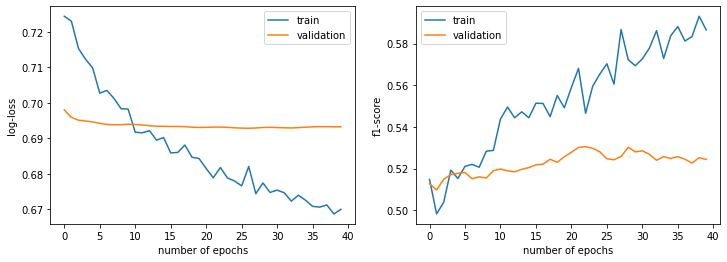

In [49]:
trainer.plot_training_loss()